In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import yaml

from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# local imports
from hydra import compose, initialize
from src.data_processing.model_analyzers.xgb_analyzers.XGBRegAnalyzer import XGBRegAnalyzer, XGBRegAnalyzerFactory
from src.data_processing.model_analyzers.xgb_analyzers.XGBRegrResults import XGBRegrResults
from src.data_processing.model_analyzers.experimenters.experimenters import XGBRegExperimenter
from src.data_processing.model_analyzers.experimenters.batch_experimenters import XGBRegBatchExperimenter


# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

In [52]:
from dataclasses import dataclass
from typing import List, Dict, Any
from pathlib import Path
from functools import lru_cache


class ExperiemntAnalyzer:
    def __init__(self, main_path: Path):
        self.main_path = main_path
    

    @property
    def baseline_experiment_results_paths(self)-> Dict[str, Path]:
        paths = {d.name: d for d in self.main_path.iterdir() if d.name.endswith("results")}
        return paths
        
    @property
    def elastic_net_main_path(self)->Path:
        for d in self.main_path.iterdir():
            if d.name.endswith("net"):
                return d
            
    @property
    def elastic_net_experiment_results_paths(self)-> Dict[str, Path]:
        paths = {d.name: d for d in self.elastic_net_main_path.iterdir() if d.name.endswith("results")}
        return paths
    @property
    def all_results_path(self) -> Dict[str, Dict[str, Path]]:
        return {"baseline": self.baseline_experiment_results_paths, "elastic_net": self.elastic_net_experiment_results_paths}
    
    


da_path = Path('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg')
dopamine_only = ExperiemntAnalyzer(da_path)
# dopamine_only.experiment_results_paths

In [102]:
(metrics.reset_index()
               .rename(columns={'index': 'dataset'})
               .melt(id_vars="dataset", value_vars=["mean_squared_error", "mean_absolute_error", "r2_score"], var_name="metric")
               )

,dataset,metric,value
0,train,mean_squared_error,9.378982e-08
1,dev,mean_squared_error,2.183535e-01
2,test,mean_squared_error,4.465580e-02
3,train,mean_squared_error,1.230758e-07
4,dev,mean_squared_error,3.754126e-02
...,...,...,...
175,dev,r2_score,-3.397369e+00
176,test,r2_score,-4.704508e-01
177,train,r2_score,9.999989e-01
178,dev,r2_score,-2.033875e-01




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



AttributeError: Rectangle.set() got an unexpected keyword argument 'capthickness'

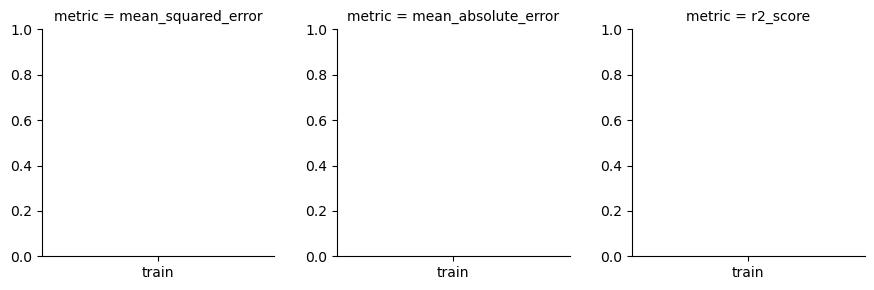

In [109]:
# test_path = dopamine_only.all_results_path['baseline']['with_day_experiment_results']
# for f in test_path.iterdir():
#     if f.name.endswith('parquet'):

        
metrics = pd.read_parquet("/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/with_day_experiment_results/metric_results.parquet")
importance = pd.read_parquet("/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/with_day_experiment_results/feature_importance_results.parquet")


def plot_metrics(df):
    metrics = (df
               .reset_index()
               .rename(columns={'index': 'dataset'})
               .melt(id_vars="dataset", value_vars=["mean_squared_error", "mean_absolute_error", "r2_score"], var_name="metric")
               )
    
    err_kws = {"capsize": .1, "capthickness": 1, "elinewidth": 1}
    facet = sns.FacetGrid(metrics, col="metric", sharey=False).map(
        sns.barplot,
        'dataset', 
        'value',
        order=['train', 'dev', 'test'],
        palette=['black', 'grey', 'darkred'],
        width=.9,
        edgecolor='black',
        linewidth=.5,
        **err_kws)
    facet.set_xticklabels(rotation=45)
    facet.set_ylabels("metric value")

    facet.set_titles("{col_name}")
    
plot_metrics(metrics)

In [ ]:
π

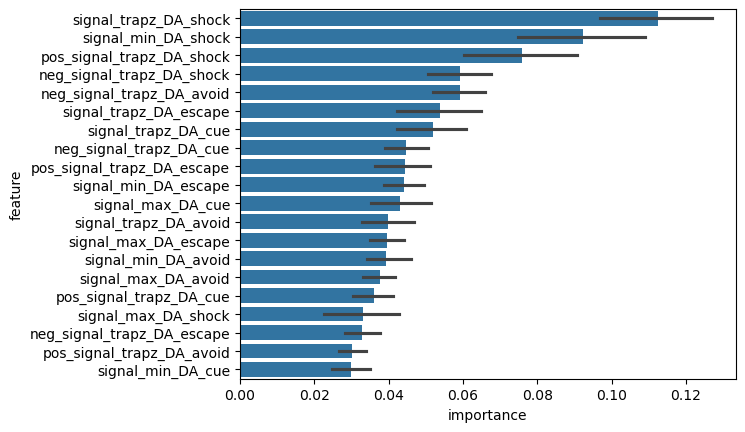

In [65]:


def plot_feature_importance_results(df):
    # Calculate the mean 'importance' for each 'feature'n
    mean_importance = df.groupby('feature')[
        'importance'].mean()

    # Sort the features by mean 'importance'
    sorted_features = mean_importance.sort_values(ascending=False).index

    # Convert 'feature' to a categorical type with its categories in the order of mean 'importance'
    df['feature'] = pd.Categorical(
        df['feature'], categories=sorted_features, ordered=True)
    
    sns.barplot(x='importance', y='feature',
                data=df, errorbar=('ci', 68), orient='h')
plot_feature_importance_results(importance)
